<a href="https://colab.research.google.com/github/Balogunhabeeb14/Personal-Projects/blob/main/Aircon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [3]:
data = pd.read_csv('/content/updated_all_data_annotation.csv')

In [4]:
data.head()

,document name,class,page number,top,left,height,width,clauses
0,AIRCONS015.pdf,High Risk,6,420.289062,87.578125,11.500000,429.328491,As a result of Contractor's participation in ...
1,AIRCONS015.pdf,High Risk,6,435.347656,71.976562,11.500000,389.638306,information and materials of a highly sensitiv...
2,AIRCONS015.pdf,High Risk,6,435.347656,464.390442,11.500000,46.685486,Contractor
3,AIRCONS015.pdf,High Risk,6,450.500000,71.976562,10.019531,429.188721,hereby warrants that Contractor and its employ...
4,AIRCONS015.pdf,High Risk,6,464.898438,71.976562,10.019531,458.921143,obtaining the Owner's prior written consent) d...


In [5]:
data.shape

(12350, 8)

In [6]:
data.columns

Index(['document name', 'class', 'page number', 'top', 'left', 'height',
       'width', 'clauses'],
      dtype='object')

In [7]:
data['class'].value_counts()

High Risk    12083
No Risk        267
Name: class, dtype: int64

In [8]:
# Define a function to count the number of words in a clause
def count_words(text):
    if isinstance(text, str):
        # Split the text into words and count them
        return len(text.split())
    else:
        return 0  # Return 0 for non-string values

# Apply the count_words function to the 'clauses' column to get the word counts for each clause
data['word_count'] = data['clauses'].apply(count_words)

# Calculate the average word count
average_word_count = data['word_count'].mean()

print("Average number of words in the 'clauses' column:", average_word_count)


Average number of words in the 'clauses' column: 5.861295546558704


In [9]:
def drop_short_clauses(df, column_name, min_word_length=5):
    # Function to check if a text has at least a certain number of words
    def has_min_word_length(text, min_word_length):
        # If the text is not a string, or contains less than the minimum number of words, return False
        if not isinstance(text, str) or len(text.split()) < min_word_length:
            return False
        return True

    # Apply the function to the specified column and filter the dataframe
    mask = df[column_name].apply(lambda x: has_min_word_length(x, min_word_length))
    filtered_df = df[mask]

    return filtered_df

# Drop rows with clauses less than one word
filtered_data = drop_short_clauses(data, 'clauses')

# Display the shape of the filtered DataFrame
filtered_data['clauses'].head(20)


0      As a result of Contractor's participation in ...
1     information and materials of a highly sensitiv...
3     hereby warrants that Contractor and its employ...
4     obtaining the Owner's prior written consent) d...
5     any person, firm, or corporation, any Confiden...
6     acquired or developed in the course of the per...
7                        days’ written notice to Owner,
8     terminate this Agreement before the completion...
9     after a progress payment is due, through no fa...
10    such termination Contractor may recover from O...
11    sustained by Contractor for materials, equipme...
12           thereon, plus loss of a reasonable profit.
13     Contractor shall replace, correct or repair a...
14    Contract Documents, applicable law and trade s...
15    Contract Documents, applicable law and trade s...
16    equipment or workmanship for a period of _____...
17            Early Termination for Breach of Contract.
20     Contractor may, on __________ days’ writt

In [10]:
filtered_data.shape

(3470, 9)

In [11]:
filtered_data.isnull().sum()

document name    0
class            0
page number      0
top              0
left             0
height           0
width            0
clauses          0
word_count       0
dtype: int64

<Axes: >

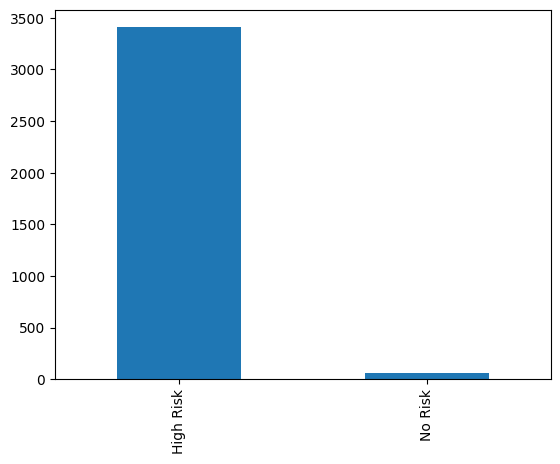

In [127]:
# Checking number of records of each label
filtered_data['class'].value_counts().plot(kind='bar')

In [13]:
df = filtered_data[['clauses','class']]
df.head()

,clauses,class
0,As a result of Contractor's participation in ...,High Risk
1,information and materials of a highly sensitiv...,High Risk
3,hereby warrants that Contractor and its employ...,High Risk
4,obtaining the Owner's prior written consent) d...,High Risk
5,"any person, firm, or corporation, any Confiden...",High Risk


In [14]:
import torch
from torch.nn.utils.rnn import pad_sequence  # Import pad_sequence function

# Assuming you've defined `num_epochs`
num_epochs = 1  # Example value

# Tokenize the text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(str(text)) for text in df['clauses']]

# Encode the tokens into input IDs
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

# Convert labels to numerical format
label_map = {"High Risk": 1, "No Risk": 0}  # Define label mapping
labels = [label_map[label] for label in df['class']]

# Split data into train and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.5, random_state=42)

# Convert input sequences to PyTorch tensors and pad them to the same length
padded_train_inputs = [torch.tensor(ids) for ids in train_inputs]
padded_train_inputs = pad_sequence(padded_train_inputs, batch_first=True)

# Create TensorDataset
train_data = TensorDataset(padded_train_inputs, torch.tensor(train_labels))

# Proceed with the rest of your code
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=2)

# Fine-tune BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 classes: High Risk, Low Risk
optimizer = AdamW(model.parameters(), lr=2e-5)

# Fine-tune BERT
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        inputs, labels = batch
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.nn import CrossEntropyLoss

# Define the loss function (criterion)
criterion = CrossEntropyLoss()

# Step 3: Evaluation
# Evaluate the fine-tuned model using validation data

# Convert validation inputs to PyTorch tensors and pad them to the same length
padded_val_inputs = [torch.tensor(ids) for ids in val_inputs]
padded_val_inputs = pad_sequence(padded_val_inputs, batch_first=True)

# Create TensorDataset for validation data
val_data = TensorDataset(padded_val_inputs, torch.tensor(val_labels))

# Create DataLoader for validation data
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=8)

model.eval()
val_loss = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        inputs, labels = batch
        outputs = model(inputs)  # Pass only inputs for inference, not labels
        logits = outputs.logits
        loss = criterion(logits, labels)  # Calculate loss if needed
        val_loss += loss.item()
        predicted_labels.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

# Calculate evaluation metrics
val_loss /= len(val_dataloader)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Validation Loss: 0.0939
Accuracy: 0.9816
Precision: 0.9816
Recall: 1.0000
F1 Score: 0.9907


In [26]:
# Save the fine-tuned BERT model
output_model_file = "fine_tuned_bert_model.pth"
torch.save(model.state_dict(), output_model_file)

'''# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load(output_model_file))
model.eval()  # Set the model to evaluation mode'''


"# Load the saved model\nmodel = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)\nmodel.load_state_dict(torch.load(output_model_file))\nmodel.eval()  # Set the model to evaluation mode"

In [30]:
pip install pyPDF2 PyMuPDF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 12.6 MB/s eta 0:00:00


In [36]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import PyPDF2
import fitz  # PyMuPDF

# Load the saved model
model_path = "/content/fine_tuned_bert_model.pth"
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    text = ''
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page_number in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_number]
            text += page.extract_text()
    return text

# Function to split text into smaller segments
def split_text(text, max_segment_length):
    segments = []
    current_segment = ''
    for word in text.split():
        if len(current_segment) + len(word) < max_segment_length:
            current_segment += ' ' + word
        else:
            segments.append(current_segment.strip())
            current_segment = word
    if current_segment:
        segments.append(current_segment.strip())
    return segments

# Function to highlight text in PDF
def highlight_text(pdf_path, segments, labels):
    doc = fitz.open(pdf_path)
    for i, (segment, label) in enumerate(zip(segments, labels)):
        if i >= len(doc):  # Check if the page index is within the document's range
            continue
        page = doc[i]
        text_instances = page.search_for(segment)
        for inst in text_instances:
            highlight = page.add_highlight_annot(inst)
            if label == 'High Risk':
                highlight.set_colors({"stroke":(1, 0, 0)})  # Red color for high risk
    doc.save("/content/highlighted_contract1.pdf")

# Highlight clauses of concern in the PDF
highlight_text(pdf_path, segments, predicted_labels)

# Extract text from PDF
pdf_path = '/content/construction-contract-template.pdf'
pdf_text = extract_text_from_pdf(pdf_path)

# Split text into smaller segments
max_segment_length = 512  # Maximum sequence length for BERT
segments = split_text(pdf_text, max_segment_length)

# Perform predictions on each segment
predicted_labels = []

for segment in segments:
    tokenized_text = tokenizer.tokenize(segment)
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)

    with torch.no_grad():
        inputs = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
        outputs = model(inputs)
        predictions = torch.argmax(outputs.logits, dim=1).tolist()

    predicted_labels.extend(predictions)

# Map numerical predictions back to class labels
predicted_labels = ['High Risk' if pred == 1 else 'No Risk' for pred in predicted_labels]

# Highlight clauses of concern in the PDF
highlight_text(pdf_path, segments, predicted_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
